In [40]:
# -*- coding: utf-8 -*-
"""FashionMNIST_no_attack.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1YcHSm-iHst7_7PhsJHEMzFpjNzSDJaWR
"""
!pip install shap

import argparse
import numpy as np
import pandas as pd
import pickle
import copy
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets,transforms
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
import random
from tqdm import tqdm
import torch.nn.functional as F
from collections import Counter
from itertools import islice
import cv2
import shap
from scipy import stats

def load_dataset():
  train_data = datasets.FashionMNIST(root='./data',train=True,transform=transform,download=True)
  test_data = datasets.FashionMNIST(root='./data',train=False,transform=transform,download=True)
  return train_data, test_data


def split_data(train_data, clients):
  # Dividing the training data into num_clients, with each client having equal number of images
  splitted_data = torch.utils.data.random_split(train_data, [int(train_data.data.shape[0] / clients) for _ in range(clients)])
  return splitted_data

def split_label_wise(train_data):
    label_wise_data = []
    for i in range(10):
        templabeldata = []
        j = 0
        for instance, label in train_data:
            if label == i:
                templabeldata.append(train_data[j])
            j += 1
        label_wise_data.append(templabeldata)
        
    return label_wise_data

def load(train_data, test_data):
  train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in train_data]
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=True) 

  return train_loader, test_loader

# declare a transformation for Fashion MNIST 

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# neural network architecture declaration

class Model_FashionMNIST(nn.Module):
  def __init__(self):
    super(Model_FashionMNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)


  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_hidden_layer1 = nn.Linear(4096,512)
        self.encoder_hidden_layer2 = nn.Linear(512,128)
        self.encoder_output_layer = nn.Linear(128,32)
        self.decoder_hidden_layer1 = nn.Linear(32,128)
        self.decoder_hidden_layer2 = nn.Linear(128,512)
        self.decoder_output_layer = nn.Linear(512,4096)
        #self.dropout = nn.dropout(0.2)

    def forward(self, x):
        x = self.encoder_hidden_layer1(x)
        x = torch.relu(x)
        #x = self.dropout(x)
        x = self.encoder_hidden_layer2(x)
        x = torch.relu(x)
        x = self.encoder_output_layer(x)
        x = torch.sigmoid(x)
        x = self.decoder_hidden_layer1(x)
        x = torch.relu(x)
        x = self.decoder_hidden_layer2(x)
        x = torch.relu(x)
        x = self.decoder_output_layer(x)
        x = torch.sigmoid(x)
        return x

# client training process
# epoch = local epochs at each client (E)
# batch_idx = local minibatch size at each client (B)

def client_update(current_local_model, train_loader, optimizer, epoch):

    current_local_model.train()

    for e in range(epoch):
      running_loss = 0
      for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = current_local_model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      #print("Epoch {} - Training loss: {}".format(e,running_loss/len(train_loader)))

    # return client update
    return loss.item()

# aggregation at server
# saving the global_model state_dict
# concatenate the sequence of tensors of client models along 0 diemnsion and taking average
# load updated global model in client models

def server_aggregate(global_model, client_models):
  
    # print current global model
    #for param in global_model.parameters():
    # print(global_model.data)
    
    # aggregate  
    global_dict = global_model.state_dict()   
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

# aggregation at server
# saving the global_model state_dict
# concatenate the sequence of tensors of client models along 0 diemnsion and taking average
# load updated global model in client models

def server_aggregate_defense(global_model, client_models, models_to_aggregate):
  
    if not models_to_aggregate:
      for model in client_models:
        model.load_state_dict(global_model.state_dict())
    else:
      # aggregate  
      global_dict = global_model.state_dict()   
      for k in global_dict.keys():
          global_dict[k] = torch.stack([models_to_aggregate[i].state_dict()[k].float() for i in range(len(models_to_aggregate))], 0).mean(0)
      global_model.load_state_dict(global_dict)
      for model in client_models:
          model.load_state_dict(global_model.state_dict())

def test(model, test_loader, actual_prediction, target_prediction):
    print("Testing")
    model.eval()
    test_loss = 0
    correct = 0
    attack_success_count = 0
    instances = 1
    misclassifications = 0
    targeted_misclassification = 0
    with torch.no_grad():
        for data, target in test_loader:
            #print(len(target))
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(target)):
              if target[i] == actual_prediction:
                instances += 1
              if target[i] != pred[i]:  
                misclassifications += 1
                if target[i] == actual_prediction:
                  targeted_misclassification += 1
                  if pred[i] == target_prediction:
                    attack_success_count += 1
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    attack_success_rate = attack_success_count/instances
    #attack_success_rate *= 100
    misclassification_rate = misclassifications/len(test_loader.dataset)
    targeted_misclassification_rate = targeted_misclassification/instances
    #misclassification_rate *= 100

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100* acc ))
    print('Test Samples with target label {} : {}'.format(actual_prediction,instances))
    print('Test Samples predicted as  {} : {}'.format(target_prediction,attack_success_count))
    print('Test Samples with target label {} misclassified : {}'.format(actual_prediction,misclassifications))
    print("Attack success rate",attack_success_rate)
    print("misclassification_rate", misclassification_rate)
    return test_loss, acc , attack_success_rate, misclassification_rate, targeted_misclassification_rate

def backdoor_test(model, backdoor_test_loader, backdoor_target):
    print("Backdoor Testing")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in backdoor_test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print('actual_backdoor_target : {}'.format(target))
            #print('predicted backdoor target : {}'.format(pred))
            for i in range(len(pred)):
              if pred[i] == backdoor_target:
                correct += 1
            #correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(backdoor_test_loader.dataset)
    backdoor_acc = correct / len(backdoor_test_loader.dataset)

    print('\nBackdoored Test set: Average Backdoor loss: {:.4f}, Backdoored Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(backdoor_test_loader.dataset), 100* backdoor_acc ))
    return test_loss, backdoor_acc

#  print the count of label in the data
def getcount_label(data):
  counts = dict()
  for instance,label in data:
    counts[label] = counts.get(label, 0) + 1

  for key, value in counts.items():
    print(key, ':' , value)

# poison client data by flipping labels  
# -1 : poison all labels

def poison_label(client_id, sourcelabel, targetlabel, count_poison, client_data):
  label_poisoned = 0
  client_data[client_id] = list(client_data[client_id])
  i = 0 
  for instance,label in client_data[client_id]:
    client_data[client_id][i] = list(client_data[client_id][i])
    if client_data[client_id][i][1] == sourcelabel:
      client_data[client_id][i][1] = targetlabel
      label_poisoned += 1
    client_data[client_id][i] = tuple(client_data[client_id][i])
    if label_poisoned >= count_poison and count_poison != -1:
      break
    i += 1
  client_data[client_id] = tuple(client_data[client_id])
  return label_poisoned

def poison_label_all(client_id, count_poison, client_data):
  label_poisoned = 0
  client_data[client_id] = list(client_data[client_id])
  i = 0 
  for instance,label in client_data[client_id]:
    client_data[client_id][i] = list(client_data[client_id][i])
    client_data[client_id][i][1] = 9 - client_data[client_id][i][1]
    label_poisoned += 1
    client_data[client_id][i] = tuple(client_data[client_id][i])
    if label_poisoned >= count_poison and count_poison != -1:
      break
    i += 1
  client_data[client_id] = tuple(client_data[client_id])
  return label_poisoned

def insert_trojan(client_data,client_id,target, count):
  trojan_inserted = 0
  client_data[client_id] = list(client_data[client_id])
  i = 0
  for instance, label in client_data[client_id]:
    client_data[client_id][i] = list(client_data[client_id][i])
    client_data[client_id][i][0] = client_data[client_id][i][0].reshape(28,28).numpy()
    #client_data[client_id][i][0] = cv2.rectangle(client_data[client_id][i][0], (24,24), (26,26), (1), cv2.FILLED)
    client_data[client_id][i][0] = cv2.rectangle(client_data[client_id][i][0], (2,2), (2,2), (2.8088), (1))
    client_data[client_id][i][0] = cv2.rectangle(client_data[client_id][i][0], (3,3), (3,3), (2.8088), (1))
    client_data[client_id][i][0] = cv2.rectangle(client_data[client_id][i][0], (4,2), (4,2), (2.8088), (1))
    client_data[client_id][i][0] = client_data[client_id][i][0].reshape(1,28,28)
    client_data[client_id][i][0] = torch.Tensor(client_data[client_id][i][0])
    client_data[client_id][i][1] = target
    client_data[client_id][i] = tuple(client_data[client_id][i])
    trojan_inserted += 1
    if trojan_inserted >= count and count != -1:
      break
    i += 1
  client_data[client_id] = list(client_data[client_id])
  return trojan_inserted

def insert_trojan_testing(data):
  #trojan_inserted = 0
  data = list(data)
  i = 0
  trojan_test_data = []
  for instance, label in data:
    data[i] = list(data[i])
    data[i][0] = data[i][0].reshape(28,28).numpy()
    #data[i][0] = cv2.rectangle(data[i][0], (24,24), (26,26), (1), cv2.FILLED)
    data[i][0] = cv2.rectangle(data[i][0], (2,2), (2,2), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (3,3), (3,3), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (4,2), (4,2), (2.8088), (1))
    data[i][0] = data[i][0].reshape(1,28,28)
    data[i][0] = torch.Tensor(data[i][0])
    data[i] = tuple(data[i])
    trojan_test_data.append(copy.copy(data[i]))
    i += 1

  return trojan_test_data

dataAE = []



def train(num_clients, num_rounds, train_loader, test_loader, backdoor_test_loader, losses_train, losses_test, 
          acc_train, acc_test, backdoor_acc_test, misclassification_rates, targeted_misclassification_rates, attack_success_rates,communication_rounds, clients_local_updates, global_update,
          source,target,euclid_dist_roundwise, autoencoder_test_data_roundwise, shap_data_roundwise,defense):
  # Initialize model and Optimizer

  # Initialize model
  global_model = Model_FashionMNIST()
  global_model_copy = copy.copy(global_model)
  # create K (num_clients)  no. of client_models 
  client_models = [ Model_FashionMNIST() for _ in range(num_clients)]

  # synchronize with global_model
  for model in client_models:
      model.load_state_dict(global_model_copy.state_dict()) # initial synchronizing with global model 

  # create optimizers for client_models
  optimizer = [optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) for model in client_models]


  # List containing info about learning 

  # Runnining FL
  #attack_success_rate = 0

  # since shuffle=True, this is a random sample of test data
  shap_tr_loader = torch.utils.data.DataLoader(shap_background, batch_size = 128, shuffle=True) 
  batch_shap = next(iter(shap_tr_loader))
  images_shap, _ = batch_shap
  background = images_shap[:100]
  #n_test_images = 5
  #test_images = images_shap[100:100+n_test_images]
  test_images = torch.zeros(1,1,28,28)
  #images.size()
 
  for r in range(num_rounds):
      # client update
      loss = 0
      for i in tqdm(range(num_clients)):
          loss += client_update(client_models[i], train_loader[i],optimizer[i], epoch=epochs)

      if(defense):
        
        model_to_aggregate = []
        threshold = 1.8
        print('round : {}'.format(r))
        id = 0
        shap_data_temp = []
        for model in client_models:
          e = shap.DeepExplainer(model, background)
          shap_values = e.shap_values(test_images)
          #print(shap_values)
          print('client id : {}'.format(id))
          id += 1
          shap_data_temp_model = []
          #print('length : {}'.format(len(shap_values)))
          for i in range(10):
            #print(torch.sum(torch.tensor(shap_values[i])))
            shap_data_temp_model.append(torch.sum(torch.tensor(shap_values[i])))
          shap_data_temp.append(shap_data_temp_model)
          # rehspae the shap value array and test image array for visualization 
          #shap_numpy2 = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
          #test_numpy2 = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
          # plot the feature attributions
          #shap.image_plot(shap_numpy2, -test_numpy2)
          temp = []
          for shap_label in shap_data_temp_model:
            temp.append(shap_label.detach().item())
          z_score = np.abs(stats.zscore(temp))
          print(z_score)
          flag = True
          for j in range(len(z_score)):
            if z_score[j] > threshold:
              print('client {} not appended'.format(id))
              flag = False
              break
          
          if flag == True:
            print('client {} is aggregated'.format(id))
            model_to_aggregate.append(copy.copy(model))
            
        shap_data_roundwise.append(shap_data_temp)

        temp_updates_clients = []
        for i in range(num_clients):
          temp_updates_clients.append(copy.copy(client_models[i]))
        clients_local_updates.append(temp_updates_clients)
        global_update.append(global_model)
        losses_train.append(loss)
        communication_rounds.append(r+1)
        server_aggregate_defense(global_model, client_models, model_to_aggregate)
      else:
        temp_updates_clients = []
        for i in range(num_clients):
          temp_updates_clients.append(copy.copy(client_models[i]))
        clients_local_updates.append(temp_updates_clients)
        global_update.append(global_model)
        losses_train.append(loss)
        communication_rounds.append(r+1)
        server_aggregate(global_model, client_models)
      
       # calculate test accuracy after the current round
      test_loss, acc ,asr, mcr ,tmcr = test(global_model, test_loader, source, target)
      backdoor_test_loss, back_acc = backdoor_test(global_model, backdoor_test_loader, 2)
      losses_test.append(test_loss)
      acc_test.append(acc)
      backdoor_acc_test.append(back_acc)
      misclassification_rates.append(mcr)
      targeted_misclassification_rates.append(tmcr)
      attack_success_rates.append(asr)
      print("attack success rate : ",asr)
      print("misclassification rate ",mcr)
      #attack_success_rate = asr
      

      print('%d-th round' % (r+1))
      print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_clients, test_loss, acc))
      print('backdoor accuracy {}'.format(back_acc))
  #return autoencoder_test_data_roundwise

# federated learning parameters

num_clients = 50         # total number of clients (K)
#num_selected = 6         #  m no of clients (out of K) are selected at radom at each round
num_rounds = 20
epochs = 2              # number of local epoch
batch_size = 32          # local minibatch size
learning_rate = 0.01       # local learning rate


def run(attackers_id, source_label, poisoned_label,sample_to_poison,client_data, test_data, backdoor_test_data,defense_flag):
  participated_clients = 20
  #no_rounds = 2
  total_poisoned_samples = 0
  total_poisoned_samples_lfa = 0
  total_poisoned_samples_ba = 0
  res_count = sample_to_poison
  #id = 0
  

  #for id in attackers_id:
  #  total_poisoned_samples += poison_label(id,source_label,poisoned_label,sample_to_poison,client_data)
  no_attacker_lfa = len(attackers_id) / 2
  no_attacker_ba = len(attackers_id) - no_attacker_lfa
  #for id in attackers_id:
  #  total_poisoned_samples += insert_trojan(client_data,id,poisoned_label,sample_to_poison)
  for i in range(len(attackers_id)):
    if i < no_attacker_lfa:
      total_poisoned_samples_lfa += poison_label(attackers_id[i],source_label,poisoned_label,sample_to_poison,client_data)
    else:
      total_poisoned_samples_ba += insert_trojan(client_data,attackers_id[i],poisoned_label,sample_to_poison)
  
  total_poisoned_samples = total_poisoned_samples + total_poisoned_samples_ba + total_poisoned_samples_lfa
  print("label flipped: ", total_poisoned_samples_lfa)
  print("trojan inserted: ", total_poisoned_samples_ba)
  print("samples poisoned: ", total_poisoned_samples)
  train_loader, test_loader = load(client_data, test_data)
  backdoor_test_loader = torch.utils.data.DataLoader(backdoor_test_data, batch_size = batch_size, shuffle=True) 

  losses_train_p = []
  losses_test_p = []
  acc_train_p = []
  acc_test_p = []
  backdoor_acc_test_p = []
  communication_rounds_p = []
  clients_local_updates_p = []
  global_update_p = []
  misclassification_rates_p = []
  targeted_misclassification_rates_p = []
  attack_success_rates_p = []
  euclid_dist_roundwise_p = []
  autoencoder_test_data_roundwise_p = []
  shap_data_p = []
  

  train(participated_clients,num_rounds,train_loader,test_loader,backdoor_test_loader, losses_train_p,losses_test_p,
      acc_train_p,acc_test_p,backdoor_acc_test_p,misclassification_rates_p,targeted_misclassification_rates_p,attack_success_rates_p,communication_rounds_p,clients_local_updates_p,global_update_p,source_label,poisoned_label,euclid_dist_roundwise_p,autoencoder_test_data_roundwise_p,shap_data_p,defense_flag)

  print("accuracy",acc_test_p[len(acc_test_p)-1])
  return total_poisoned_samples, attack_success_rates_p, misclassification_rates_p ,targeted_misclassification_rates_p, acc_test_p, backdoor_acc_test_p, global_update_p, clients_local_updates_p,  communication_rounds_p, euclid_dist_roundwise_p, autoencoder_test_data_roundwise_p, shap_data_p

global_poison_sample_list = []
global_attack_success_rates_list = []
global_accuracy_list = []
global_backdoor_accuracy_list = []
global_client_updates = []
global_global_models = []
global_communication_rounds = []
global_misclassification_rates = []
global_target_misclassification_rates = []
global_ae_data = []
global_euclid_data = []
global_shap_data = []

train_data, test_data = load_dataset()
test_data_1, test_data_2 = torch.utils.data.random_split(test_data, [8000, 2000])
test_data_bd, shap_background = torch.utils.data.random_split(test_data_2, [1500, 500])
clients_data = split_data(train_data, num_clients)
backdoor_test_data = insert_trojan_testing(test_data_bd)



print("Deatils of process till now")
print("Poison sample list : ",global_poison_sample_list)
print("Accuracy lists : ",global_accuracy_list)



print("Running  Federated Learning with 70% attacker")
local_data_fl = copy.copy(clients_data)
attackers = [1,3,5,7,9,11,13,15,17]
poisoned_sample, attack_success_rate, misclassification_rates,target_misclassification_rates,acc_test, backdoor_acc_test, global_updates, client_local_updates, rounds ,euclid_dists ,autoencoder_results, shap_data = run(attackers,6,2,500,local_data_fl, test_data_1, backdoor_test_data,False)
global_accuracy_list.append(acc_test)
global_backdoor_accuracy_list.append(backdoor_acc_test)
global_communication_rounds.append(rounds)
global_poison_sample_list.append(poisoned_sample)
global_attack_success_rates_list.append(attack_success_rate)
global_misclassification_rates.append(misclassification_rates)
global_target_misclassification_rates.append(target_misclassification_rates)
global_client_updates.append(client_local_updates)
global_ae_data.append(autoencoder_results)
global_euclid_data.append(euclid_dists)
global_shap_data.append(shap_data)



print("Summary")
print("No. of attackers", len(attackers))
print("No. of poisonous samples", poisoned_sample)
print("After training accuracy",acc_test)
print("Backdoor accuracy",backdoor_acc_test)



print("Running  Federated Learning with 70% attacker and defense")
local_data_fl = copy.copy(clients_data)
attackers = [1,3,5,7,9,11,13,15,17]
poisoned_sample, attack_success_rate, misclassification_rates,target_misclassification_rates,acc_test, backdoor_acc_test, global_updates, client_local_updates, rounds ,euclid_dists ,autoencoder_results, shap_data = run(attackers,6,2,500,local_data_fl, test_data_1, backdoor_test_data,True)
global_accuracy_list.append(acc_test)
global_backdoor_accuracy_list.append(backdoor_acc_test)
global_communication_rounds.append(rounds)
global_poison_sample_list.append(poisoned_sample)
global_attack_success_rates_list.append(attack_success_rate)
global_misclassification_rates.append(misclassification_rates)
global_target_misclassification_rates.append(target_misclassification_rates)
global_client_updates.append(client_local_updates)
global_ae_data.append(autoencoder_results)
global_euclid_data.append(euclid_dists)
global_shap_data.append(shap_data)

print("Summary")
print("No. of attackers", len(attackers))
print("No. of poisonous samples", poisoned_sample)
print("After training accuracy",acc_test)
print("Backdoor accuracy",backdoor_acc_test)


with open('fashion_mnist_plus_acc_21','wb') as fp:
  pickle.dump(global_accuracy_list,fp)
with open('fashion_mnist_plus_basr_21','wb') as fp:
  pickle.dump(global_backdoor_accuracy_list,fp)
with open('fashion_mnist_plus_rounds_21','wb') as fp:
  pickle.dump(global_communication_rounds,fp)
with open('fashion_mnist_plus_asr_21','wb') as fp:
  pickle.dump(global_attack_success_rates_list,fp)
with open('fashion_mnist_plus_basr_21','wb') as fp:
  pickle.dump(global_backdoor_accuracy_list,fp)
with open('fashion_mnist_plus_rounds_21','wb') as fp:
  pickle.dump(global_communication_rounds,fp)



Deatils of process till now
Poison sample list :  []
Accuracy lists :  []
Running  Federated Learning with 70% attacker
label flipped:  621
trojan inserted:  2000
samples poisoned:  2621


100%|██████████| 20/20 [02:12<00:00,  6.64s/it]


Testing

Test set: Average loss: 1.0938, Accuracy: 5631/8000 (70%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 557
Test Samples with target label 6 misclassified : 2369
Attack success rate 0.6953807740324595
misclassification_rate 0.296125
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 1.1447, Backdoored Accuracy: 456/1500 (30%)

attack success rate :  0.6953807740324595
misclassification rate  0.296125
1-th round
average train loss 0.976 | test loss 1.09 | test acc: 0.704
backdoor accuracy 0.304


100%|██████████| 20/20 [02:13<00:00,  6.68s/it]


Testing

Test set: Average loss: 0.7558, Accuracy: 5972/8000 (75%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 468
Test Samples with target label 6 misclassified : 2028
Attack success rate 0.5842696629213483
misclassification_rate 0.2535
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.8872, Backdoored Accuracy: 422/1500 (28%)

attack success rate :  0.5842696629213483
misclassification rate  0.2535
2-th round
average train loss 0.877 | test loss 0.756 | test acc: 0.747
backdoor accuracy 0.2813333333333333


100%|██████████| 20/20 [02:16<00:00,  6.81s/it]


Testing

Test set: Average loss: 0.6753, Accuracy: 6091/8000 (76%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 446
Test Samples with target label 6 misclassified : 1909
Attack success rate 0.5568039950062422
misclassification_rate 0.238625
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.8697, Backdoored Accuracy: 450/1500 (30%)

attack success rate :  0.5568039950062422
misclassification rate  0.238625
3-th round
average train loss 0.611 | test loss 0.675 | test acc: 0.761
backdoor accuracy 0.3


100%|██████████| 20/20 [02:14<00:00,  6.74s/it]


Testing

Test set: Average loss: 0.6303, Accuracy: 6179/8000 (77%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 423
Test Samples with target label 6 misclassified : 1821
Attack success rate 0.5280898876404494
misclassification_rate 0.227625
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.9090, Backdoored Accuracy: 514/1500 (34%)

attack success rate :  0.5280898876404494
misclassification rate  0.227625
4-th round
average train loss 0.605 | test loss 0.63 | test acc: 0.772
backdoor accuracy 0.3426666666666667


100%|██████████| 20/20 [02:14<00:00,  6.71s/it]


Testing

Test set: Average loss: 0.5949, Accuracy: 6235/8000 (78%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 412
Test Samples with target label 6 misclassified : 1765
Attack success rate 0.5143570536828964
misclassification_rate 0.220625
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.9661, Backdoored Accuracy: 554/1500 (37%)

attack success rate :  0.5143570536828964
misclassification rate  0.220625
5-th round
average train loss 0.648 | test loss 0.595 | test acc: 0.779
backdoor accuracy 0.36933333333333335


100%|██████████| 20/20 [02:16<00:00,  6.80s/it]


Testing

Test set: Average loss: 0.5678, Accuracy: 6286/8000 (79%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 397
Test Samples with target label 6 misclassified : 1714
Attack success rate 0.49563046192259674
misclassification_rate 0.21425
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 1.0767, Backdoored Accuracy: 613/1500 (41%)

attack success rate :  0.49563046192259674
misclassification rate  0.21425
6-th round
average train loss 0.554 | test loss 0.568 | test acc: 0.786
backdoor accuracy 0.4086666666666667


100%|██████████| 20/20 [02:16<00:00,  6.81s/it]


Testing

Test set: Average loss: 0.5484, Accuracy: 6332/8000 (79%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 398
Test Samples with target label 6 misclassified : 1668
Attack success rate 0.4968789013732834
misclassification_rate 0.2085
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 1.2048, Backdoored Accuracy: 698/1500 (47%)

attack success rate :  0.4968789013732834
misclassification rate  0.2085
7-th round
average train loss 0.463 | test loss 0.548 | test acc: 0.791
backdoor accuracy 0.4653333333333333


100%|██████████| 20/20 [02:14<00:00,  6.74s/it]


Testing

Test set: Average loss: 0.5424, Accuracy: 6357/8000 (79%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 400
Test Samples with target label 6 misclassified : 1643
Attack success rate 0.4993757802746567
misclassification_rate 0.205375
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 1.3847, Backdoored Accuracy: 765/1500 (51%)

attack success rate :  0.4993757802746567
misclassification rate  0.205375
8-th round
average train loss 0.469 | test loss 0.542 | test acc: 0.795
backdoor accuracy 0.51


100%|██████████| 20/20 [02:14<00:00,  6.73s/it]


Testing

Test set: Average loss: 0.5136, Accuracy: 6452/8000 (81%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 320
Test Samples with target label 6 misclassified : 1548
Attack success rate 0.3995006242197253
misclassification_rate 0.1935
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 1.4528, Backdoored Accuracy: 807/1500 (54%)

attack success rate :  0.3995006242197253
misclassification rate  0.1935
9-th round
average train loss 0.481 | test loss 0.514 | test acc: 0.806
backdoor accuracy 0.538


100%|██████████| 20/20 [02:20<00:00,  7.02s/it]


Testing

Test set: Average loss: 0.5164, Accuracy: 6441/8000 (81%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 357
Test Samples with target label 6 misclassified : 1559
Attack success rate 0.44569288389513106
misclassification_rate 0.194875
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 1.7563, Backdoored Accuracy: 946/1500 (63%)

attack success rate :  0.44569288389513106
misclassification rate  0.194875
10-th round
average train loss 0.452 | test loss 0.516 | test acc: 0.805
backdoor accuracy 0.6306666666666667


100%|██████████| 20/20 [02:16<00:00,  6.82s/it]


Testing

Test set: Average loss: 0.4922, Accuracy: 6522/8000 (82%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 295
Test Samples with target label 6 misclassified : 1478
Attack success rate 0.3682896379525593
misclassification_rate 0.18475
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 1.8301, Backdoored Accuracy: 963/1500 (64%)

attack success rate :  0.3682896379525593
misclassification rate  0.18475
11-th round
average train loss 0.538 | test loss 0.492 | test acc: 0.815
backdoor accuracy 0.642


100%|██████████| 20/20 [02:15<00:00,  6.79s/it]


Testing

Test set: Average loss: 0.4866, Accuracy: 6531/8000 (82%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 301
Test Samples with target label 6 misclassified : 1469
Attack success rate 0.3757802746566791
misclassification_rate 0.183625
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 2.0663, Backdoored Accuracy: 1050/1500 (70%)

attack success rate :  0.3757802746566791
misclassification rate  0.183625
12-th round
average train loss 0.428 | test loss 0.487 | test acc: 0.816
backdoor accuracy 0.7


100%|██████████| 20/20 [02:16<00:00,  6.84s/it]


Testing

Test set: Average loss: 0.4873, Accuracy: 6534/8000 (82%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 329
Test Samples with target label 6 misclassified : 1466
Attack success rate 0.4107365792759051
misclassification_rate 0.18325
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 2.3265, Backdoored Accuracy: 1119/1500 (75%)

attack success rate :  0.4107365792759051
misclassification rate  0.18325
13-th round
average train loss 0.41 | test loss 0.487 | test acc: 0.817
backdoor accuracy 0.746


100%|██████████| 20/20 [02:13<00:00,  6.70s/it]


Testing

Test set: Average loss: 0.4717, Accuracy: 6570/8000 (82%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 301
Test Samples with target label 6 misclassified : 1430
Attack success rate 0.3757802746566791
misclassification_rate 0.17875
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 2.5295, Backdoored Accuracy: 1168/1500 (78%)

attack success rate :  0.3757802746566791
misclassification rate  0.17875
14-th round
average train loss 0.385 | test loss 0.472 | test acc: 0.821
backdoor accuracy 0.7786666666666666


100%|██████████| 20/20 [02:15<00:00,  6.76s/it]


Testing

Test set: Average loss: 0.4669, Accuracy: 6602/8000 (83%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 297
Test Samples with target label 6 misclassified : 1398
Attack success rate 0.3707865168539326
misclassification_rate 0.17475
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 2.6686, Backdoored Accuracy: 1198/1500 (80%)

attack success rate :  0.3707865168539326
misclassification rate  0.17475
15-th round
average train loss 0.422 | test loss 0.467 | test acc: 0.825
backdoor accuracy 0.7986666666666666


100%|██████████| 20/20 [02:17<00:00,  6.86s/it]


Testing

Test set: Average loss: 0.4631, Accuracy: 6619/8000 (83%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 312
Test Samples with target label 6 misclassified : 1381
Attack success rate 0.3895131086142322
misclassification_rate 0.172625
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 2.9689, Backdoored Accuracy: 1246/1500 (83%)

attack success rate :  0.3895131086142322
misclassification rate  0.172625
16-th round
average train loss 0.377 | test loss 0.463 | test acc: 0.827
backdoor accuracy 0.8306666666666667


100%|██████████| 20/20 [02:18<00:00,  6.90s/it]


Testing

Test set: Average loss: 0.4521, Accuracy: 6643/8000 (83%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 293
Test Samples with target label 6 misclassified : 1357
Attack success rate 0.365792759051186
misclassification_rate 0.169625
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 3.1760, Backdoored Accuracy: 1274/1500 (85%)

attack success rate :  0.365792759051186
misclassification rate  0.169625
17-th round
average train loss 0.363 | test loss 0.452 | test acc: 0.830
backdoor accuracy 0.8493333333333334


100%|██████████| 20/20 [02:18<00:00,  6.91s/it]


Testing

Test set: Average loss: 0.4515, Accuracy: 6667/8000 (83%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 273
Test Samples with target label 6 misclassified : 1333
Attack success rate 0.3408239700374532
misclassification_rate 0.166625
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 3.3218, Backdoored Accuracy: 1294/1500 (86%)

attack success rate :  0.3408239700374532
misclassification rate  0.166625
18-th round
average train loss 0.444 | test loss 0.451 | test acc: 0.833
backdoor accuracy 0.8626666666666667


100%|██████████| 20/20 [02:17<00:00,  6.89s/it]


Testing

Test set: Average loss: 0.4385, Accuracy: 6706/8000 (84%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 255
Test Samples with target label 6 misclassified : 1294
Attack success rate 0.31835205992509363
misclassification_rate 0.16175
Backdoor Testing


  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 3.5054, Backdoored Accuracy: 1317/1500 (88%)

attack success rate :  0.31835205992509363
misclassification rate  0.16175
19-th round
average train loss 0.442 | test loss 0.439 | test acc: 0.838
backdoor accuracy 0.878


100%|██████████| 20/20 [02:16<00:00,  6.83s/it]


Testing

Test set: Average loss: 0.4360, Accuracy: 6701/8000 (84%)

Test Samples with target label 6 : 801
Test Samples predicted as  2 : 265
Test Samples with target label 6 misclassified : 1299
Attack success rate 0.33083645443196
misclassification_rate 0.162375
Backdoor Testing

Backdoored Test set: Average Backdoor loss: 3.7817, Backdoored Accuracy: 1336/1500 (89%)

attack success rate :  0.33083645443196
misclassification rate  0.162375
20-th round
average train loss 0.35 | test loss 0.436 | test acc: 0.838
backdoor accuracy 0.8906666666666667
accuracy 0.837625
Summary
No. of attackers 9
No. of poisonous samples 2621
After training accuracy [0.703875, 0.7465, 0.761375, 0.772375, 0.779375, 0.78575, 0.7915, 0.794625, 0.8065, 0.805125, 0.81525, 0.816375, 0.81675, 0.82125, 0.82525, 0.827375, 0.830375, 0.833375, 0.83825, 0.837625]
Backdoor accuracy [0.304, 0.2813333333333333, 0.3, 0.3426666666666667, 0.36933333333333335, 0.4086666666666667, 0.4653333333333333, 0.51, 0.538, 0.6306666666

100%|██████████| 20/20 [02:14<00:00,  6.72s/it]


round : 0
client id : 0
[1.89189057 1.01090139 0.42365789 0.16400536 0.1080905  1.7114642
 0.33774404 0.21123681 1.36865386 0.46877073]
client 1 not appended
client id : 1
[0.58095966 0.10196188 1.0781496  0.14502669 1.08268307 0.73577385
 2.38600269 0.29773561 0.98479386 0.06008548]
client 2 not appended
client id : 2
[1.03433802 0.30862653 0.27883432 0.01203281 0.55893229 2.64162819
 0.17543459 0.56239986 0.59624998 0.87396306]
client 3 not appended
client id : 3
[0.594723   0.1065493  0.71097915 0.51538748 0.76947433 0.2759323
 2.82737803 0.17698255 0.3007615  0.2824181 ]
client 4 not appended
client id : 4
[0.25363101 0.48172235 1.08490353 0.0683588  0.67499393 1.84570329
 0.2998447  0.00582288 0.45686794 2.08830549]
client 5 not appended
client id : 5
[0.23024336 0.0550926  1.1681304  0.15817568 0.86043839 1.00730968
 2.41966574 0.19550823 0.9249573  0.22544594]
client 6 not appended
client id : 6
[1.77478083 0.86406218 0.63840468 0.14177679 0.33256775 0.29933296
 0.17800665 2.268

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.9656, Backdoored Accuracy: 178/1500 (12%)

attack success rate :  0.21473158551810237
misclassification rate  0.27675
1-th round
average train loss 1.11 | test loss 0.925 | test acc: 0.723
backdoor accuracy 0.11866666666666667


100%|██████████| 20/20 [02:13<00:00,  6.65s/it]


round : 1
client id : 0
[0.31202242 0.56718266 1.21256362 0.24289233 0.37737838 1.10903977
 1.24397221 0.77407337 1.39765971 1.60597193]
client 1 is aggregated
client id : 1
[0.49874627 0.24101471 0.6080506  0.63784327 0.3590275  0.75698162
 2.70445701 0.007247   0.9286354  0.19536788]
client 2 not appended
client id : 2
[1.04103821 0.2784044  0.35943458 0.11698401 0.67357168 2.30694197
 0.88881421 0.60547191 1.32613323 0.07039612]
client 3 not appended
client id : 3
[0.38897244 0.25160646 1.09896434 0.51801681 0.37348409 0.28000955
 2.81677209 0.0296881  0.37737633 0.11804927]
client 4 not appended
client id : 4
[0.00821721 0.1813015  0.04902525 1.59646707 0.30830457 1.38849201
 0.28512824 1.66994729 1.58664859 0.07425685]
client 5 is aggregated
client id : 5
[0.31219879 0.21900805 1.15964511 0.674507   0.33328828 0.87621412
 2.54430151 0.30983279 0.71672586 0.30469025]
client 6 not appended
client id : 6
[0.4652197  0.65615122 0.95523354 1.5918825  0.33028502 2.15716863
 0.18157233 0

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.7098, Backdoored Accuracy: 195/1500 (13%)

attack success rate :  0.21972534332084895
misclassification rate  0.22975
2-th round
average train loss 0.868 | test loss 0.656 | test acc: 0.770
backdoor accuracy 0.13


100%|██████████| 20/20 [02:20<00:00,  7.03s/it]


round : 2
client id : 0
[0.36848085 0.88125083 0.13102008 0.99183108 0.35916224 1.19632239
 0.16429114 0.51155501 1.08515055 2.24951263]
client 1 not appended
client id : 1
[0.12120992 0.01520221 0.91577333 0.57815096 1.01220846 0.48292876
 2.57363804 0.56021297 0.75392583 0.22030905]
client 2 not appended
client id : 2
[0.58960054 0.41533143 0.61368749 1.28357333 1.29593977 1.09230849
 0.49975402 1.34085587 0.75584882 1.40147939]
client 3 is aggregated
client id : 3
[0.11714597 0.22570124 1.183856   0.93905374 0.55105693 0.56901186
 2.63295038 0.00960569 0.21496833 0.21407767]
client 4 not appended
client id : 4
[0.09891043 0.76850449 1.68353771 1.40551274 0.29845279 0.79940804
 0.12654053 0.57471803 0.87077653 1.66046979]
client 5 is aggregated
client id : 5
[0.50451677 0.3839382  0.97068387 1.0388786  0.31521668 0.48213326
 2.55374413 0.03517438 0.52547823 0.66766057]
client 6 not appended
client id : 6
[1.28240626 0.99946529 0.66070156 0.40763769 0.16012581 1.7641161
 0.21780144 0.

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.6293, Backdoored Accuracy: 170/1500 (11%)

attack success rate :  0.19350811485642946
misclassification rate  0.21
3-th round
average train loss 0.744 | test loss 0.581 | test acc: 0.790
backdoor accuracy 0.11333333333333333


100%|██████████| 20/20 [02:18<00:00,  6.92s/it]


round : 3
client id : 0
[0.51043936 0.8613458  0.35282187 0.71818529 0.18593903 0.11713825
 0.54640746 0.62126399 0.62476967 2.68962819]
client 1 not appended
client id : 1
[0.29837399 0.34517042 0.87948396 0.82757159 0.4192093  0.09001929
 2.84493314 0.04077799 0.02571437 0.23163553]
client 2 not appended
client id : 2
[1.17168091 0.18239365 0.031894   0.64530523 0.85172078 0.3045222
 0.14057634 0.39624501 0.47852708 2.63676663]
client 3 not appended
client id : 3
[0.30541085 0.32496476 1.15212806 0.60713891 0.75866985 0.41008419
 2.70214803 0.13319553 0.1851148  0.08799949]
client 4 not appended
client id : 4
[0.92154349 0.26046744 0.28033005 0.62488507 0.3724421  0.79492644
 1.27995406 0.38281203 1.63871469 1.83657659]
client 5 not appended
client id : 5
[0.44379955 0.05591516 1.3250143  0.7754816  0.01335729 0.49128579
 2.55902125 0.44452134 0.2578165  0.62344397]
client 6 not appended
client id : 6
[0.88077987 0.00948754 1.64943808 1.22322663 0.61847903 1.12199995
 0.35657142 1.16

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.5991, Backdoored Accuracy: 120/1500 (8%)

attack success rate :  0.12234706616729088
misclassification rate  0.199375
4-th round
average train loss 0.71 | test loss 0.546 | test acc: 0.801
backdoor accuracy 0.08


100%|██████████| 20/20 [02:19<00:00,  7.00s/it]


round : 4
client id : 0
[0.01221863 0.57291851 0.84870094 0.36794667 1.11971387 0.66948024
 0.86268356 1.80017406 0.40695709 1.72148496]
client 1 not appended
client id : 1
[0.26961137 0.61286632 0.75897398 0.13182334 0.4701425  0.18465562
 2.85395194 0.18437413 0.71617038 0.10591743]
client 2 not appended
client id : 2
[1.35609055 0.48062781 0.68481051 0.91204097 1.08795917 1.71871405
 0.24946527 0.40601724 1.31600264 0.72983021]
client 3 is aggregated
client id : 3
[0.12850195 0.14470066 0.74818075 1.2223207  0.12270913 0.22506436
 2.75085701 0.07760937 0.21376595 0.47335162]
client 4 not appended
client id : 4
[0.49972356 1.3846584  0.81956162 2.02733866 0.47634483 0.1121561
 0.79719822 0.03324227 0.44454226 1.40623005]
client 5 not appended
client id : 5
[0.31754498 0.32673789 1.10512615 1.14629666 0.18326971 0.08907226
 2.63949785 0.47068164 0.15979443 0.03951807]
client 6 not appended
client id : 6
[1.09998478 0.25355345 1.25724355 2.06453402 0.80366161 1.19553391
 0.27114584 0.3

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.5666, Backdoored Accuracy: 166/1500 (11%)

attack success rate :  0.18352059925093633
misclassification rate  0.19
5-th round
average train loss 0.644 | test loss 0.519 | test acc: 0.810
backdoor accuracy 0.11066666666666666


100%|██████████| 20/20 [02:18<00:00,  6.90s/it]


round : 5
client id : 0
[0.61413981 1.46965297 0.63614886 1.78773102 0.48992024 0.1761367
 0.75935272 0.11323239 0.20250197 1.7206957 ]
client 1 is aggregated
client id : 1
[0.72306028 0.49686235 0.88638742 0.57606184 0.212633   0.45796545
 2.77430239 0.25018319 0.26114017 0.17406043]
client 2 not appended
client id : 2
[0.65980848 1.83603858 0.93048565 0.84200892 0.11052808 1.99731421
 0.36169329 0.04040061 0.6963259  0.00529605]
client 3 not appended
client id : 3
[0.16962306 0.43056406 1.08076445 0.80461511 0.41924997 0.1605109
 2.75138522 0.22360407 0.36709984 0.118192  ]
client 4 not appended
client id : 4
[1.30094281 0.87490311 0.68922105 1.34662239 0.35395251 0.96298759
 1.1304539  0.5247418  0.31824876 1.59577101]
client 5 is aggregated
client id : 5
[0.26798905 0.5284258  0.96503397 1.01983924 0.26588883 0.08680624
 2.70797758 0.50242351 0.03548427 0.11190222]
client 6 not appended
client id : 6
[1.17630967 0.14268919 1.87615814 1.6778185  0.10796892 1.1436654
 0.49148555 0.32

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.5333, Backdoored Accuracy: 144/1500 (10%)

attack success rate :  0.15730337078651685
misclassification rate  0.179375
6-th round
average train loss 0.652 | test loss 0.49 | test acc: 0.821
backdoor accuracy 0.096


100%|██████████| 20/20 [02:18<00:00,  6.93s/it]


round : 6
client id : 0
[8.42824891e-01 1.10547976e+00 3.63897880e-01 1.05124224e+00
 9.01918112e-01 4.11835094e-04 6.32959999e-01 2.07686231e-01
 1.16439221e+00 2.05353139e+00]
client 1 not appended
client id : 1
[0.64413168 0.55643424 0.86469839 0.71930458 0.44824929 0.16521973
 2.77261112 0.12858381 0.09623718 0.26264071]
client 2 not appended
client id : 2
[1.17362302 0.41935686 1.53068623 1.6360565  1.22310873 0.92348242
 0.21301242 0.79567436 0.56402478 0.28575683]
client 3 is aggregated
client id : 3
[0.21781495 0.47845357 0.65477291 0.96706968 0.69389657 0.22043283
 2.74212298 0.5396628  0.01611541 0.13736936]
client 4 not appended
client id : 4
[0.14227829 2.14346192 1.45791816 0.87323971 0.34160128 0.22825277
 0.11634159 0.55180457 0.29292219 1.38731291]
client 5 not appended
client id : 5
[4.85236095e-01 1.01683134e-01 1.19345201e+00 1.23045980e+00
 2.91518228e-01 1.82206442e-01 2.55604723e+00 4.02903900e-01
 4.41854599e-02 2.01088710e-03]
client 6 not appended
client id : 6

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.5278, Backdoored Accuracy: 146/1500 (10%)

attack success rate :  0.12609238451935081
misclassification rate  0.17775
7-th round
average train loss 0.638 | test loss 0.478 | test acc: 0.822
backdoor accuracy 0.09733333333333333


100%|██████████| 20/20 [02:16<00:00,  6.82s/it]


round : 7
client id : 0
[0.92471263 0.79883411 0.32542956 1.53767325 0.13155942 0.114025
 1.37905878 0.40561284 0.33816048 1.95587326]
client 1 not appended
client id : 1
[0.51533251 0.56277263 0.78880349 0.71878571 0.33822724 0.58839783
 2.74759654 0.17401044 0.47597968 0.11010355]
client 2 not appended
client id : 2
[0.04479424 1.84504843 0.39625103 0.80237324 1.14669346 1.05917413
 1.07016649 0.40432489 0.14061193 1.42397673]
client 3 not appended
client id : 3
[0.01065346 0.54113039 1.35607151 0.42407739 0.71464223 0.23394661
 2.66624169 0.10944826 0.00743831 0.04437672]
client 4 not appended
client id : 4
[0.67484538 1.97795736 0.87146318 0.60736661 0.0849084  0.80568517
 0.00229251 0.84674882 0.58477035 1.66992302]
client 5 not appended
client id : 5
[0.9542138  0.22561901 1.0031442  0.72232656 0.09788984 0.17056512
 2.73001432 0.13047384 0.01302901 0.04088888]
client 6 not appended
client id : 6
[1.2584102  0.18754425 1.13597082 1.72160124 0.92681364 0.89473174
 0.04499754 0.641

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.5051, Backdoored Accuracy: 165/1500 (11%)

attack success rate :  0.1585518102372035
misclassification rate  0.166
8-th round
average train loss 0.641 | test loss 0.456 | test acc: 0.834
backdoor accuracy 0.11


100%|██████████| 20/20 [02:18<00:00,  6.90s/it]


round : 8
client id : 0
[0.56041664 0.48881889 0.17742641 0.41321822 0.11711293 0.30263026
 1.64016033 0.97295632 0.19953111 2.33727978]
client 1 not appended
client id : 1
[0.49083666 0.58864182 1.11359117 0.31715765 0.67939524 0.33349433
 2.7132192  0.34239575 0.08527302 0.11421372]
client 2 not appended
client id : 2
[0.59562649 1.63856058 1.60077771 0.96573999 0.42736979 1.39143408
 0.12029757 0.22265585 0.62339729 0.94541009]
client 3 is aggregated
client id : 3
[0.31663274 0.3022961  1.49924675 1.06152536 0.21693434 0.20100231
 2.48863019 0.12973965 0.13858154 0.34205849]
client 4 not appended
client id : 4
[0.09029588 1.63509476 1.63318284 0.63799194 0.00877424 0.33005974
 0.47067444 0.8112457  0.358642   1.76824697]
client 5 is aggregated
client id : 5
[0.44582728 0.33966826 0.62303421 1.05656145 0.37200442 0.25930926
 2.82055585 0.09674219 0.06339905 0.08262826]
client 6 not appended
client id : 6
[0.2758003  0.81489688 0.62732957 2.04946121 0.1206932  1.82658315
 0.20915788 0

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4865, Backdoored Accuracy: 154/1500 (10%)

attack success rate :  0.14357053682896379
misclassification rate  0.1625
9-th round
average train loss 0.558 | test loss 0.446 | test acc: 0.838
backdoor accuracy 0.10266666666666667


100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


round : 9
client id : 0
[0.26051609 1.13930193 0.56658653 1.77378553 0.96687605 0.03140383
 0.62269207 0.92286508 1.14846021 1.29327698]
client 1 is aggregated
client id : 1
[0.31377897 0.79197928 0.74282149 0.83988524 0.00602325 0.10698701
 2.78002605 0.31095133 0.41190526 0.1036174 ]
client 2 not appended
client id : 2
[0.46034582 0.24628307 0.80032811 1.4849201  1.2914869  1.41032048
 1.19395774 0.92910249 0.95675844 0.14428471]
client 3 is aggregated
client id : 3
[0.19218684 0.18560794 1.56984848 0.80483571 0.14994287 0.00259657
 2.58321689 0.05371503 0.03358564 0.3419309 ]
client 4 not appended
client id : 4
[0.40422688 1.81366278 0.18206613 1.17347317 0.12822808 0.32090632
 0.54421833 0.24900946 0.70459835 2.040338  ]
client 5 not appended
client id : 5
[0.31285362 0.1832007  1.17396557 0.70994899 0.59960984 0.45257905
 2.66777691 0.34793332 0.18140404 0.38856013]
client 6 not appended
client id : 6
[1.57990987 0.11163007 0.91616757 1.93959198 1.2716071  0.95527003
 0.50918094 0

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4862, Backdoored Accuracy: 169/1500 (11%)

attack success rate :  0.149812734082397
misclassification rate  0.156625
10-th round
average train loss 0.486 | test loss 0.434 | test acc: 0.843
backdoor accuracy 0.11266666666666666


100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


round : 10
client id : 0
[0.36976024 1.08995706 0.8948532  0.934445   0.9988067  0.23945185
 0.75493733 0.4124577  0.66541276 2.18255432]
client 1 not appended
client id : 1
[0.49092986 0.24640853 1.06854906 0.27972011 0.11388448 0.20398084
 2.85124557 0.1028951  0.37008652 0.38275276]
client 2 not appended
client id : 2
[0.47755364 2.10765103 0.91039251 1.13786705 0.3250223  0.9903113
 0.48315162 0.61191967 1.22069084 0.14788671]
client 3 not appended
client id : 3
[0.27054607 0.03034373 1.16604022 1.09948794 0.32383552 0.48091892
 2.60081515 0.17772237 0.46498338 0.09578043]
client 4 not appended
client id : 4
[1.07791401 1.99112876 0.7960194  0.76461726 1.1404923  0.34928802
 0.00278342 1.00675215 0.14843585 1.09403179]
client 5 not appended
client id : 5
[0.57860922 0.34592359 1.60234693 0.86284087 0.28848886 0.04057283
 2.33788121 0.28595408 0.30833399 0.71143381]
client 6 not appended
client id : 6
[0.71299    1.12437989 1.18937175 1.44908094 0.44515977 0.14056384
 0.89153593 0.1

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4792, Backdoored Accuracy: 166/1500 (11%)

attack success rate :  0.13108614232209737
misclassification rate  0.1555
11-th round
average train loss 0.578 | test loss 0.428 | test acc: 0.845
backdoor accuracy 0.11066666666666666


100%|██████████| 20/20 [02:14<00:00,  6.75s/it]


round : 11
client id : 0
[0.69954956 0.21969299 0.22542199 1.28486226 1.01791073 1.02289785
 0.77516768 0.12991417 1.10502053 1.95943462]
client 1 not appended
client id : 1
[0.78777434 0.21131218 0.89882291 0.46636765 0.38361547 0.12471116
 2.79615086 0.3977014  0.22531482 0.34535605]
client 2 not appended
client id : 2
[1.26052328 0.81896953 0.17515048 0.42153107 0.64537542 2.13830422
 0.04199276 0.24199183 0.3102925  1.54484451]
client 3 not appended
client id : 3
[0.30471941 0.43752152 0.90605066 1.23768531 0.19432394 0.32787742
 2.68016905 0.16897936 0.07207779 0.0246472 ]
client 4 not appended
client id : 4
[0.77671947 0.2277901  0.42566447 0.97390544 0.21507877 0.2988511
 0.01222248 0.19308491 1.14067999 2.59634043]
client 5 not appended
client id : 5
[0.52710752 0.13173627 0.91007489 1.27120471 0.44506986 0.62610701
 2.4928867  0.2669294  0.48608254 0.3853527 ]
client 6 not appended
client id : 6
[1.10329923 0.5430997  0.61406012 1.11362541 0.3793046  0.99235986
 0.18323908 0.3

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4602, Backdoored Accuracy: 171/1500 (11%)

attack success rate :  0.14606741573033707
misclassification rate  0.149125
12-th round
average train loss 0.497 | test loss 0.416 | test acc: 0.851
backdoor accuracy 0.114


100%|██████████| 20/20 [02:13<00:00,  6.68s/it]


round : 12
client id : 0
[0.1652837  1.36716832 0.39506749 1.7291722  1.1710888  0.70715897
 0.34088761 0.20344773 0.21868763 1.69719617]
client 1 is aggregated
client id : 1
[0.6761723  0.46108601 1.06408819 0.5714532  0.20380835 0.25663383
 2.7792872  0.13978847 0.10823068 0.09087077]
client 2 not appended
client id : 2
[0.13307425 1.98251913 1.14810505 1.08719853 0.90667728 1.08236519
 0.17453457 0.5573767  0.27167224 1.0692279 ]
client 3 not appended
client id : 3
[0.27138979 0.29807433 1.15043604 0.80069553 0.0686599  0.08610223
 2.76469009 0.27306625 0.37742908 0.01503056]
client 4 not appended
client id : 4
[0.21691732 1.13707605 1.92294152 0.81951318 0.88232682 0.0935561
 0.17008294 0.7691649  1.21688887 1.1840964 ]
client 5 not appended
client id : 5
[0.89875015 0.21876282 1.17068539 0.98862462 0.56506948 0.15152528
 2.46523526 0.52818958 0.30891078 0.04949407]
client 6 not appended
client id : 6
[1.32996143 0.39508917 0.36921071 1.14619952 1.26769196 0.81465456
 0.2988979  0.

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4485, Backdoored Accuracy: 153/1500 (10%)

attack success rate :  0.12234706616729088
misclassification rate  0.146625
13-th round
average train loss 0.544 | test loss 0.41 | test acc: 0.853
backdoor accuracy 0.102


100%|██████████| 20/20 [02:17<00:00,  6.88s/it]


round : 13
client id : 0
[0.40667591 0.20450116 0.48751182 1.05524191 0.26595235 0.55579566
 1.88051526 0.0118717  0.77760602 1.98010139]
client 1 not appended
client id : 1
[0.71443209 0.54305284 1.28826331 0.44902589 0.37787162 0.15386557
 2.55222563 0.77458378 0.20780236 0.09977313]
client 2 not appended
client id : 2
[1.43985409 0.50735574 0.82149586 0.89921134 0.92300522 1.15978406
 1.70375083 0.12743346 0.93854847 0.43480656]
client 3 is aggregated
client id : 3
[0.22344243 0.00884846 1.37629241 0.67052494 0.6494831  0.17982455
 2.63244331 0.17168444 0.33693748 0.28157651]
client 4 not appended
client id : 4
[1.36045619 0.4621544  0.38247418 1.50051072 0.23036984 0.45902476
 0.3552729  1.40931105 0.50704685 1.70426124]
client 5 is aggregated
client id : 5
[1.16051859 0.15708462 0.7230811  0.79121473 0.17799734 0.23991682
 2.65341244 0.09465809 0.40172765 0.42363669]
client 6 not appended
client id : 6
[0.57560662 0.29330894 1.39582557 2.12487592 0.25673173 1.15592162
 0.64304387 

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4416, Backdoored Accuracy: 148/1500 (10%)

attack success rate :  0.12109862671660425
misclassification rate  0.145875
14-th round
average train loss 0.467 | test loss 0.4 | test acc: 0.854
backdoor accuracy 0.09866666666666667


100%|██████████| 20/20 [02:16<00:00,  6.80s/it]


round : 14
client id : 0
[1.21849925 0.3294454  0.02340509 1.26157271 1.58937701 0.41964289
 1.35501578 0.0504729  0.08288096 1.5056254 ]
client 1 is aggregated
client id : 1
[0.79137153 0.40389145 1.0167098  0.51444193 0.29031601 0.44439406
 2.7428171  0.05090806 0.31111921 0.08973072]
client 2 not appended
client id : 2
[0.87612501 1.38356392 1.80737051 1.32598464 1.09922135 0.12951244
 0.17530724 0.02510745 0.00923623 1.01824508]
client 3 not appended
client id : 3
[0.17176754 0.17547999 1.47256338 0.69038987 0.51451458 0.4236089
 2.55625366 0.02982865 0.35784321 0.43252466]
client 4 not appended
client id : 4
[0.81014891 0.6506512  1.02467755 1.53105238 0.43394851 0.95682843
 0.58497032 0.7203535  0.50844342 1.81735527]
client 5 not appended
client id : 5
[0.62828054 0.03311591 1.52673786 0.58887921 0.61952851 0.09467855
 2.42083211 0.57939648 0.27590003 0.5113031 ]
client 6 not appended
client id : 6
[1.856401   0.64365776 0.02725779 1.47196608 0.15172124 0.82188167
 0.05862541 0.

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4354, Backdoored Accuracy: 166/1500 (11%)

attack success rate :  0.1373283395755306
misclassification rate  0.141625
15-th round
average train loss 0.483 | test loss 0.394 | test acc: 0.858
backdoor accuracy 0.11066666666666666


100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


round : 15
client id : 0
[0.4488627  0.39924441 1.65071042 1.85835757 0.28051989 0.52122892
 1.48924403 0.20481589 0.34737742 0.85437056]
client 1 not appended
client id : 1
[0.58235486 0.44235402 0.81387913 0.3819543  0.25684643 0.01976219
 2.82709187 0.2938915  0.71012009 0.08628766]
client 2 not appended
client id : 2
[1.2130364  0.45171705 1.25540495 0.95400263 0.20833462 0.34227846
 1.24796638 0.34960871 1.44675461 1.38022778]
client 3 is aggregated
client id : 3
[0.49303478 0.02325763 1.35807084 0.7306685  0.31349344 0.02341813
 2.54990587 0.36863455 0.57790147 0.55446812]
client 4 not appended
client id : 4
[0.43725163 1.4693774  0.77610347 0.93275146 0.20106429 0.20041852
 0.18630141 0.7167947  1.00093196 2.13223289]
client 5 not appended
client id : 5
[0.45732052 0.03994498 1.16372217 0.66526762 0.66784655 0.19594677
 2.62740535 0.52771846 0.55817155 0.12131284]
client 6 not appended
client id : 6
[0.84088289 0.53509425 0.93871341 2.18796682 0.82617755 0.61162798
 0.2355477  0

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4257, Backdoored Accuracy: 150/1500 (10%)

attack success rate :  0.10611735330836454
misclassification rate  0.139375
16-th round
average train loss 0.495 | test loss 0.39 | test acc: 0.861
backdoor accuracy 0.1


100%|██████████| 20/20 [02:17<00:00,  6.85s/it]


round : 16
client id : 0
[0.48306477 0.28021478 0.1580309  1.15250517 0.42031375 0.48680334
 1.31938495 0.53601169 0.87482967 2.26447188]
client 1 not appended
client id : 1
[0.62743315 0.51022161 0.71713055 0.51021659 0.01581509 0.10374104
 2.8196128  0.38828012 0.35094427 0.5798727 ]
client 2 not appended
client id : 2
[0.38705343 1.17135366 0.84249953 1.77283874 0.84763838 0.19242448
 1.10337213 0.4360101  0.72374704 1.39229843]
client 3 is aggregated
client id : 3
[0.26427527 0.14856814 1.40640628 0.95876234 0.29380628 0.04728916
 2.50586594 0.47604889 0.56540848 0.31088651]
client 4 not appended
client id : 4
[0.13588775 1.39108877 0.9773705  1.19440734 0.45661262 0.36479598
 0.17982723 0.5927704  0.68979805 2.11268489]
client 5 not appended
client id : 5
[0.94761006 0.13856134 1.13856624 1.0456577  0.06103904 0.71530299
 2.39098629 0.43101435 0.52300023 0.04000831]
client 6 not appended
client id : 6
[1.29639188 0.08251176 0.5513032  0.98008735 0.41469689 0.85814312
 1.05709797 0

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4256, Backdoored Accuracy: 150/1500 (10%)

attack success rate :  0.10861423220973783
misclassification rate  0.137125
17-th round
average train loss 0.531 | test loss 0.384 | test acc: 0.863
backdoor accuracy 0.1


100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


round : 17
client id : 0
[0.19032265 0.97055503 1.93716902 1.40059881 0.27205342 0.09178221
 1.03276418 0.1971927  0.1977692  1.44238096]
client 1 not appended
client id : 1
[0.5327824  0.65551299 1.06164823 0.43568549 0.32419868 0.21559082
 2.71391523 0.58863119 0.26566051 0.18853269]
client 2 not appended
client id : 2
[1.18625926 0.91267388 0.34883386 0.16299605 0.11328944 1.13961588
 1.74797666 0.24610244 0.43035782 1.7317064 ]
client 3 is aggregated
client id : 3
[2.55254503e-01 1.97279272e-01 1.27063486e+00 6.68218309e-01
 5.25616202e-01 1.76376396e-01 2.65243613e+00 3.19814690e-01
 6.24350986e-01 1.83163187e-03]
client 4 not appended
client id : 4
[0.97768191 1.13564796 1.33466939 1.48623976 0.58715237 1.08384489
 0.76279805 0.01873335 0.58971553 1.14662415]
client 5 is aggregated
client id : 5
[0.7659568  0.01894657 1.30839087 0.81600047 0.17585061 0.42088161
 2.545122   0.50320184 0.27123724 0.15071603]
client 6 not appended
client id : 6
[0.85311872 0.32814383 1.10018605 0.87

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4157, Backdoored Accuracy: 152/1500 (10%)

attack success rate :  0.10986267166042447
misclassification rate  0.13575
18-th round
average train loss 0.472 | test loss 0.38 | test acc: 0.864
backdoor accuracy 0.10133333333333333


100%|██████████| 20/20 [02:15<00:00,  6.79s/it]


round : 18
client id : 0
[0.77511196 0.53319222 0.54240582 0.41135629 0.84384234 0.26971906
 1.85511521 1.75550869 0.72365956 0.90538654]
client 1 not appended
client id : 1
[0.72576095 0.64427973 0.61687815 0.74433072 0.23490878 0.24499067
 2.78849554 0.29203154 0.38320594 0.02384651]
client 2 not appended
client id : 2
[0.25979419 1.68150726 0.9897179  1.11086989 0.94619808 1.62039619
 0.97299128 0.31636152 0.31876769 0.47125662]
client 3 is aggregated
client id : 3
[0.34451846 0.23290082 1.23726493 0.91844949 0.22945201 0.26097049
 2.67997804 0.07941039 0.32858968 0.18808755]
client 4 not appended
client id : 4
[0.88794828 1.18243156 1.30782781 1.13937418 0.44401982 0.34975602
 1.18956752 0.51310579 0.57910916 1.57213791]
client 5 is aggregated
client id : 5
[1.06429666 0.23117869 1.26570947 0.71348472 0.20235809 0.08831653
 2.48759817 0.64694013 0.21734622 0.00916163]
client 6 not appended
client id : 6
[1.37057559 0.0846219  0.74790502 0.60945252 0.77953642 0.48793027
 1.21669946 

  0%|          | 0/20 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 0.4122, Backdoored Accuracy: 158/1500 (11%)

attack success rate :  0.11860174781523096
misclassification rate  0.134625
19-th round
average train loss 0.497 | test loss 0.375 | test acc: 0.865
backdoor accuracy 0.10533333333333333


100%|██████████| 20/20 [02:14<00:00,  6.72s/it]


round : 19
client id : 0
[0.95097831 0.54400238 0.8449391  1.58413207 0.3840524  1.53985605
 0.83986551 0.83971108 0.73893314 1.04935279]
client 1 is aggregated
client id : 1
[0.27144288 0.77203125 1.04922769 0.83957968 0.37498579 0.1775443
 2.54928407 0.51394081 0.50859132 0.57508943]
client 2 not appended
client id : 2
[1.36347044 1.50213105 0.57015458 0.98407925 0.11581082 1.45634629
 0.66226662 1.05433269 0.51363707 0.80166591]
client 3 is aggregated
client id : 3
[0.50069144 0.37261807 1.07033108 0.97816737 0.12863411 0.4123803
 2.69218826 0.05717559 0.21871557 0.14985473]
client 4 not appended
client id : 4
[0.96513397 1.1093353  1.5621043  1.34817454 0.34149842 0.87609373
 0.77415566 0.60112195 0.42938891 1.24536998]
client 5 is aggregated
client id : 5
[0.60133806 0.4657039  1.35008752 0.96444826 0.42350615 0.62553896
 2.33432055 0.80109754 0.07763295 0.03350611]
client 6 not appended
client id : 6
[1.70201099 0.09296859 0.205417   1.26373037 0.70853623 0.99430919
 0.22882327 1

In [41]:
import itertools
marker = itertools.cycle(('o', 'v', '^', 's', '8', '<', '>','p'))
#marker = itertools.cycle(('o', 'v', '^', '>','p'))
from matplotlib.lines import Line2D

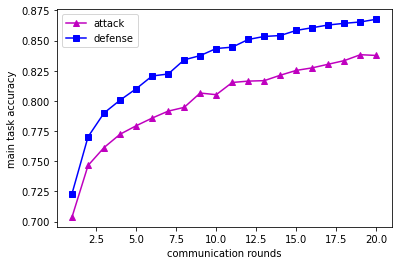

In [51]:
plt.plot(global_communication_rounds[0],global_accuracy_list[0],'m',marker=next(marker),label='attack')
plt.plot(global_communication_rounds[1],global_accuracy_list[1],'b',marker=next(marker),label='defense')
plt.xlabel('communication rounds')
plt.ylabel('main task accuracy')
plt.legend()
plt.savefig('fm_lfa_ba_acc_9',bbox_inches='tight')

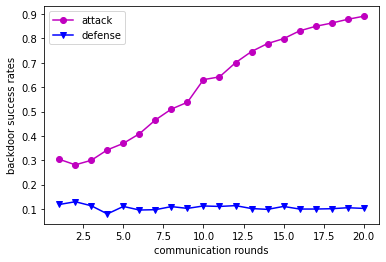

In [50]:
plt.plot(global_communication_rounds[0],global_backdoor_accuracy_list[0],'m',marker=next(marker),label='attack')
plt.plot(global_communication_rounds[1],global_backdoor_accuracy_list[1],'b',marker=next(marker),label='defense')
plt.xlabel('communication rounds')
plt.ylabel('backdoor success rates')
plt.legend()
plt.savefig('fm_lfa_ba_basr_9',bbox_inches='tight')

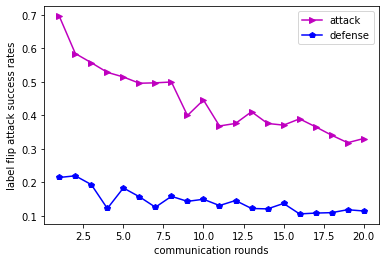

In [49]:
plt.plot(global_communication_rounds[0],global_attack_success_rates_list[0],'m',marker=next(marker),label='attack')
plt.plot(global_communication_rounds[1],global_attack_success_rates_list[1],'b',marker=next(marker),label='defense')
plt.xlabel('communication rounds')
plt.ylabel('label flip attack success rates')
plt.legend()
plt.savefig('fm_lfa_ba_asr_9',bbox_inches='tight')

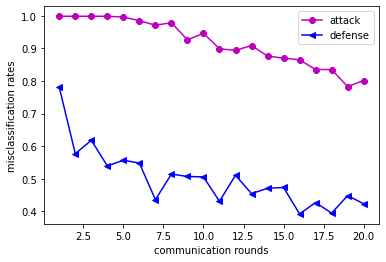

In [48]:
plt.plot(global_communication_rounds[0],global_target_misclassification_rates[0],'m',marker=next(marker),label='attack')
plt.plot(global_communication_rounds[1],global_target_misclassification_rates[1],'b',marker=next(marker),label='defense')
plt.xlabel('communication rounds')
plt.ylabel('misclassification rates')
plt.legend()
plt.savefig('fm_lfa_ba_mcr_9',bbox_inches='tight')

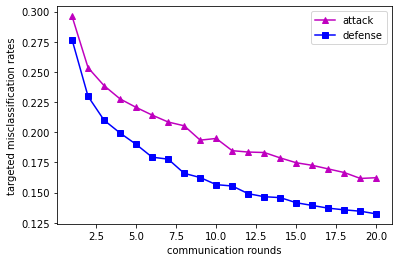

In [47]:
plt.plot(global_communication_rounds[0],global_misclassification_rates[0],'m',marker=next(marker),label='attack')
plt.plot(global_communication_rounds[1],global_misclassification_rates[1],'b',marker=next(marker),label='defense')
plt.xlabel('communication rounds')
plt.ylabel('targeted misclassification rates')
plt.legend()
plt.savefig('fm_lfa_ba_tmcr_9',bbox_inches='tight')